---

# UNIVERSITÀ DEGLI STUDI DI MILANO #

## Master in Data Science for Economics, Business and Finance ## 

### Analisi e Forecasting di una Serie Temporale ###

### Tesi di fine Master di: ###

### Claudio Panelli (Matr. A04422) ###

### Anno Accademico 2021/2022 ###

### Summary: ###

- Import Librerie Python
- Lettura dati della Time Series da CSV
- Analisi Descrittiva
- Forecasting
 - ARIMA
 - RNN
 - Prophet

---

### Import Librerie Python ###

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import plotly.express as px

import datetime
from tabulate import tabulate

from scipy.stats import boxcox

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA

from dm_test import dm_test

import time
import math

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

from keras.utils.vis_utils import plot_model

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (20, 6)

---

### Definizione parametri ###

In [3]:
filename = 'current.csv'

# nome della serie temporale scelta
timeseries = 'AWHMAN'
timestamp = 'timestamp'

# data di inizio e fine dell'analisi
start_date = '1979-12-31'
end_date = '2020-01-01'

# percentuale di split train/test
split_perc = 80

# impostazione per plotting
start_to_plot_train =  360

# data di split dati train/test
dt_start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
dt_end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
dt_split_date = dt_start_date+((dt_end_date-dt_start_date)/100)*split_perc

split_date = dt_split_date.strftime("%Y-%m-%d")

---

### Lettura dati della Time Series da CSV ###

In [4]:
df = pd.read_csv(filename, sep=',')

In [5]:
# fred data
df = df[['sasdate',timeseries]].iloc[1:, :]
df[timestamp] = pd.to_datetime(df['sasdate'])
df = df.drop('sasdate',axis=1)

In [6]:
df.shape

(758, 2)

In [7]:
print(df.head())
print(df.tail())

   AWHMAN  timestamp
1    40.2 1959-01-01
2    40.3 1959-02-01
3    40.4 1959-03-01
4    40.5 1959-04-01
5    40.7 1959-05-01
     AWHMAN  timestamp
754    41.3 2021-10-01
755    41.4 2021-11-01
756    41.3 2021-12-01
757    41.2 2022-01-01
758     NaN        NaT


---

### Analisi Descrittiva ###

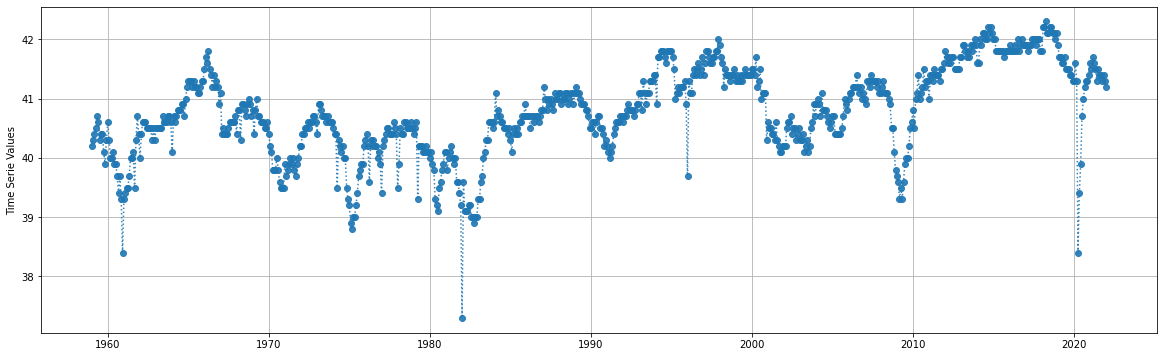

In [8]:
plt.figure(figsize=(20,6))
plt.plot(df[timestamp],df[timeseries],'o:',alpha=0.9)

plt.ylabel('Time Serie Values')
plt.grid()
plt.show()

In [9]:
# Selezione del periodo analizzato

df = df[df[timestamp] > datetime.datetime.strptime(start_date,"%Y-%m-%d")]
df = df[df[timestamp] < datetime.datetime.strptime(end_date,"%Y-%m-%d")]

In [10]:
df.shape

(480, 2)

In [11]:
print(df.head())
print(df.tail())

     AWHMAN  timestamp
253    40.0 1980-01-01
254    40.1 1980-02-01
255    39.9 1980-03-01
256    39.8 1980-04-01
257    39.3 1980-05-01
     AWHMAN  timestamp
728    41.5 2019-08-01
729    41.5 2019-09-01
730    41.4 2019-10-01
731    41.4 2019-11-01
732    41.3 2019-12-01


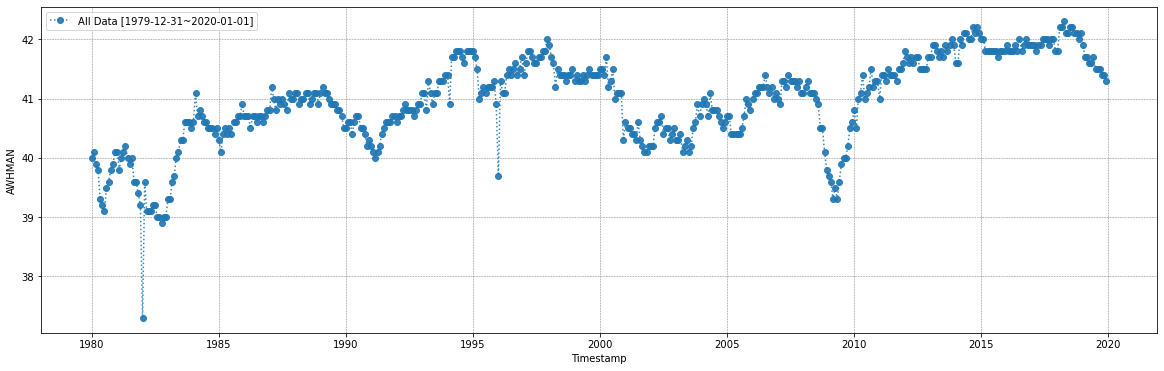

In [12]:
# Plot Serie Temporale

plt.figure(figsize=(20,6))

plt.plot(df[timestamp],df[timeseries],'o:',alpha=0.9)

plt.legend(['All Data ['+start_date+'~'+end_date+']'])
plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.savefig('TS_00_entire', bbox_inches='tight')

plt.show()

In [13]:
#Osserviamo due "Outliers": Dicembre 1960, Gennaio 1982 e Gennaio 1996

fig = px.line(df, x=timestamp, y=timeseries)
fig.show()

In [14]:
# Sostituisco gli outliers con la media dei punti pre e antecendenti

df[timeseries][ df[timestamp]=='1982-01-01' ] = (df[timeseries][ df[timestamp]=='1981-12-01' ].iloc[0]+df[timeseries][ df[timestamp]=='1982-02-01'].iloc[0])/2
df[timeseries][ df[timestamp]=='1996-01-01' ] = (df[timeseries][ df[timestamp]=='1995-12-01' ].iloc[0]+df[timeseries][ df[timestamp]=='1996-02-01'].iloc[0])/2

# Alcuni approcci prevedono l'0identificazione tramite libreria kats e la rimozione degli outliers
# Vedi: https://towardsdatascience.com/how-to-detect-seasonality-outliers-and-changepoints-in-your-time-series-5d0901498cff
#
#from kats.detectors.outlier import OutlierDetector
#outlier_detector = OutlierDetector(df, "additive")
#outlier_detector.detector()
#outliers = outlier_detector.outliers
#outliers[0]

In [15]:
fig = px.line(df, x=timestamp, y=timeseries)
fig.show()

In [16]:
# Decomponiamo la serie in trend e stagionalità ipotizzando che le componenti della TS siano additive
# ovvero y(t) = Level + Trend + Seasonality + Noise
# e una seasonality di 12 mesi
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

decomposition = seasonal_decompose(df[timeseries], model='additive', period=12)

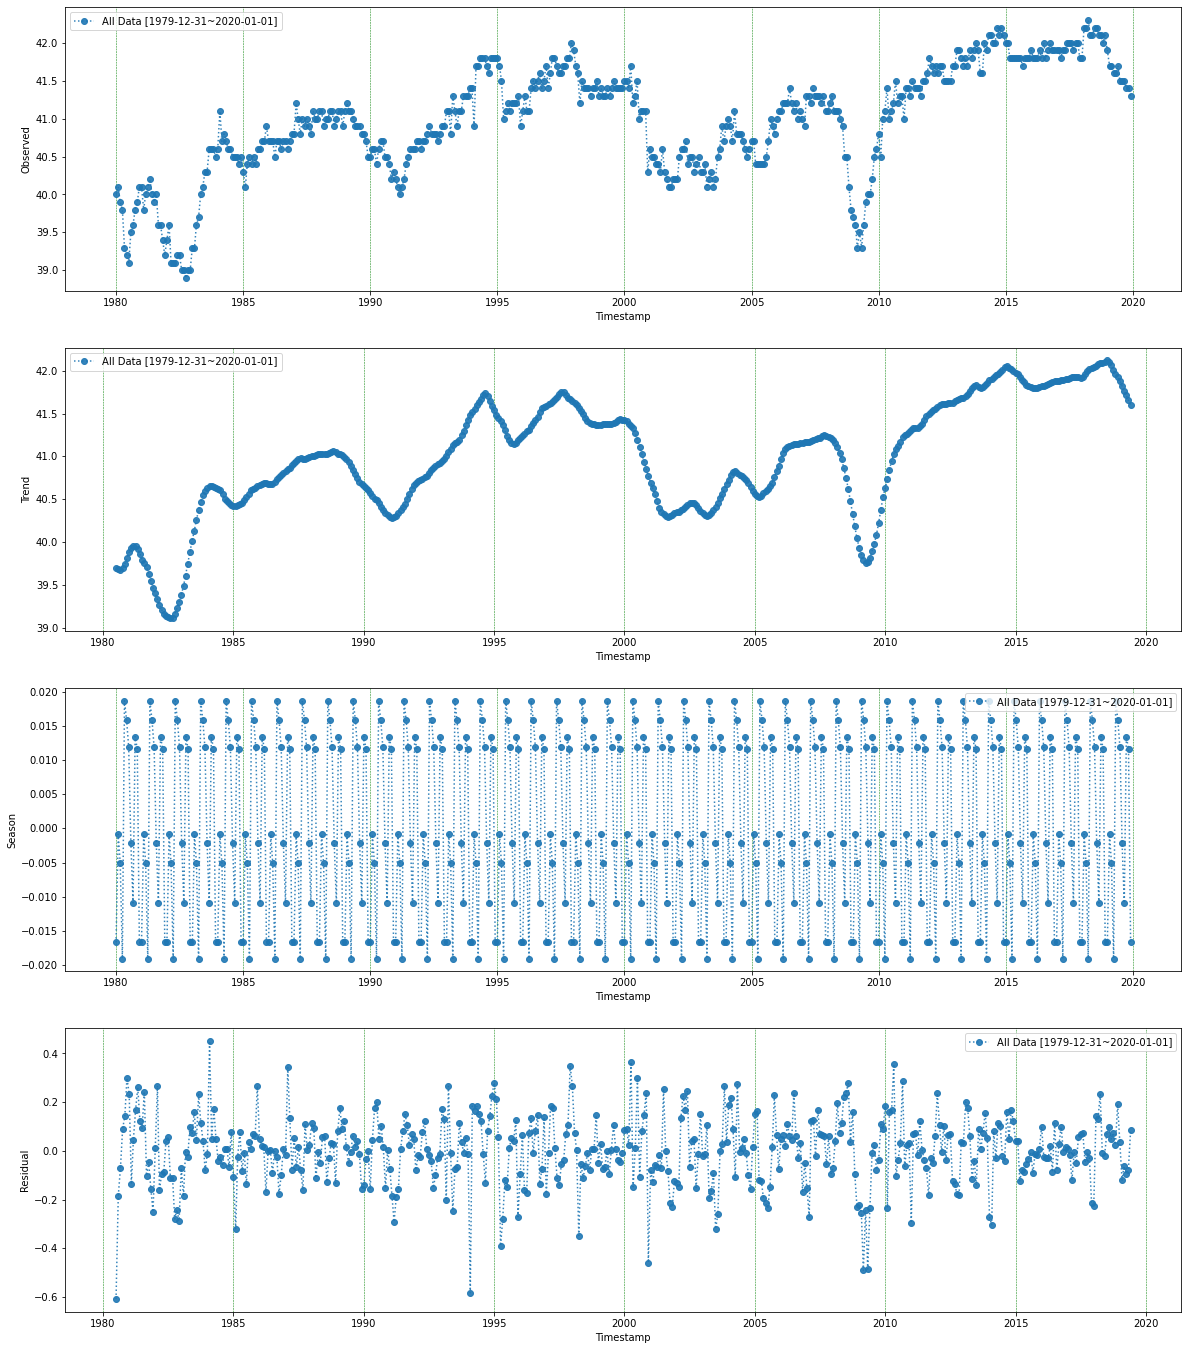

In [17]:
# Plot Trend, Seasonal e Residual

plt.figure(figsize=(20,24))

plt.subplot(411)
plt.plot(df[timestamp],decomposition.observed,'o:',alpha=0.9)
plt.legend(['All Data ['+start_date+'~'+end_date+']'])

plt.ylabel('Observed')
plt.xlabel('Timestamp')

plt.grid(axis = 'x', color = 'green', linestyle = '--', linewidth = 0.5)

plt.subplot(412)
plt.plot(df[timestamp],decomposition.trend,'o:',alpha=0.9)
plt.legend(['All Data ['+start_date+'~'+end_date+']'])

plt.ylabel('Trend')
plt.xlabel('Timestamp')

plt.grid(axis = 'x', color = 'green', linestyle = '--', linewidth = 0.5)

plt.subplot(413)
plt.plot(df[timestamp],decomposition.seasonal,'o:',alpha=0.9)
plt.legend(['All Data ['+start_date+'~'+end_date+']'])

plt.ylabel('Season')
plt.xlabel('Timestamp')

plt.grid(axis = 'x', color = 'green', linestyle = '--', linewidth = 0.5)

plt.subplot(414)
plt.plot(df[timestamp],decomposition.resid,'o:',alpha=0.9)
plt.legend(['All Data ['+start_date+'~'+end_date+']'])

plt.ylabel('Residual')
plt.xlabel('Timestamp')

plt.grid(axis = 'x', color = 'green', linestyle = '--', linewidth = 0.5)

plt.savefig('TS_00_decomposition', bbox_inches='tight')
plt.show()

In [18]:
# Split della serie in Train e Test data

df_train = df[df[timestamp] <= datetime.datetime.strptime(split_date,"%Y-%m-%d")]
df_test = df[df[timestamp] > datetime.datetime.strptime(split_date,"%Y-%m-%d")]

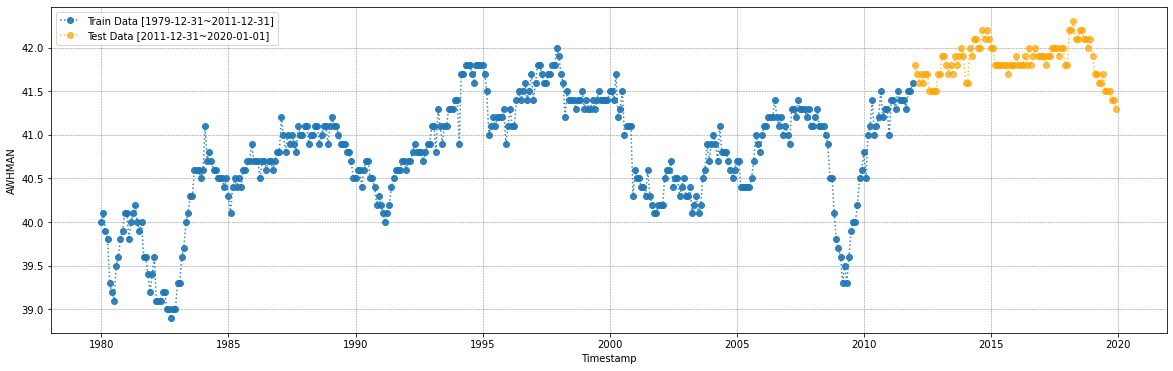

In [19]:
# Plot Serie Temporale divisa per Train e Test Data

plt.figure(figsize=(20,6))
plt.plot(df_train[timestamp],df_train[timeseries],'o:',alpha=0.9)
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

plt.legend(['Train Data ['+start_date+'~'+split_date+']','Test Data ['+split_date+'~'+end_date+']'])
plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.savefig('TS_01_train-test', bbox_inches='tight')

plt.show()

In [20]:
#print(df_train.shape)
#print(df_test.shape)

---

### Forecasting ###

#### ARIMA ####

##### Test ADF per la Stazionarietà #####

- p_value = 0.183237 < 0.05 => non possiamo rigettare l'ipotesi nulla: la serie non è stazionaria.

Non possiamo applicare i metodi ARMA/ARIMA direttamente alla serie: ipotizziamo di doverla differenziare (d>0).

In [21]:
adf = adfuller(df_train[timeseries])

print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values:')

for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
    
if adf[1] < 0.05:
    print("Time Series is Stationary")
else:
    print("Time Series is Non-Stationary")

ADF Statistic: -2.265797
p-value: 0.183237
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
Time Series is Non-Stationary


##### Ricerca valore q #####

- il grafico ACF indicherebbe la scelta di un valore di q (per la componente MA(q)) elevato, il che implicherebbe la creazione di un modello complesso;

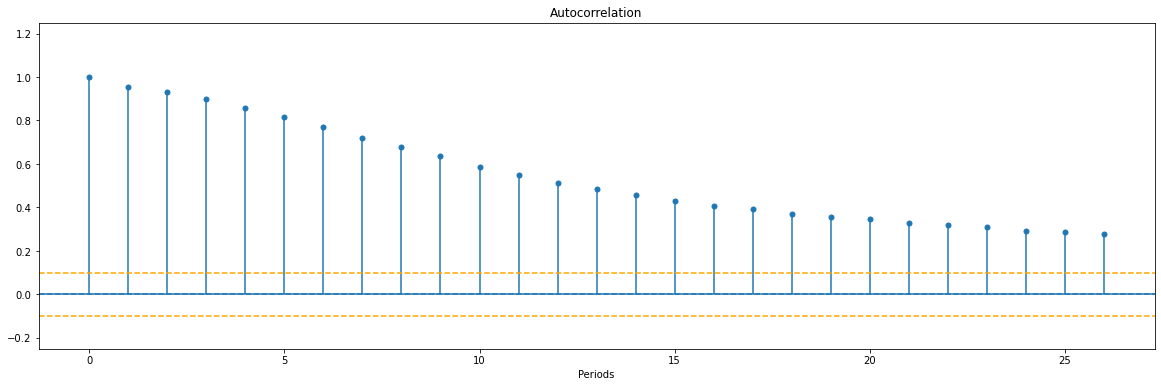

In [22]:
# ACF
acf_array = acf(df_train[timeseries])

# Plot the acf function
plot_acf(df_train[timeseries], alpha=None)

plt.axhline(y=0,linestyle='--')#, color='black')
plt.axhline(y=-1.96/np.sqrt(len(df_train[timeseries])),linestyle='--',color='orange')
plt.axhline(y=1.96/np.sqrt(len(df_train[timeseries])),linestyle='--',color='orange')

plt.xlabel('Periods')

plt.ylim([-0.25, 1.25])

plt.savefig('TS_02_acf', bbox_inches='tight')

plt.show()

##### Ricerca valore p #####

- il grafico PACF indica che un buon valore di p (per la componente AR(p)) potrebbe essere 1 oppure 2

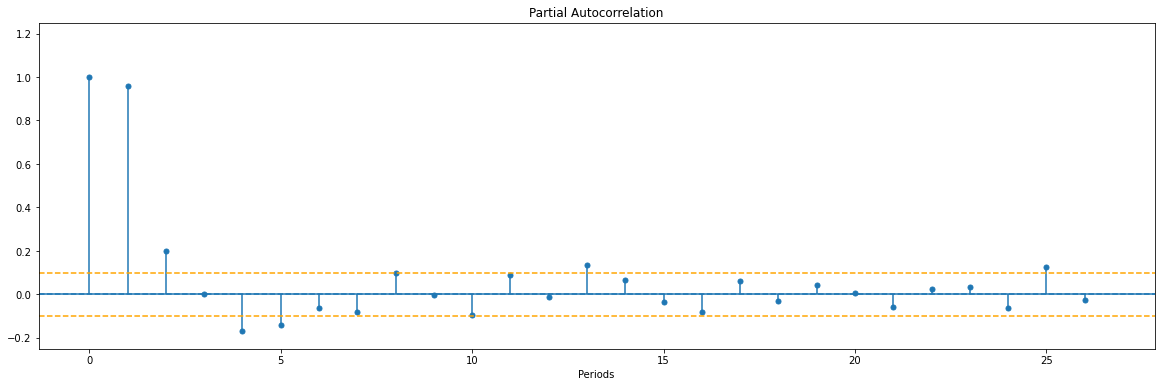

In [23]:
# PACF
pacf_array = pacf(df_train[timeseries])

# Plot the acf function
plot_pacf(df_train[timeseries], alpha=1) #, color='r');

plt.axhline(y=0,linestyle='--')# ,color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_train[timeseries])),linestyle='--',color='orange')
plt.axhline(y=1.96/np.sqrt(len(df_train[timeseries])),linestyle='--',color='orange')

plt.xlabel('Periods')

plt.ylim([-0.25, 1.25])

plt.savefig('TS_03_pacf', bbox_inches='tight')

##### Selezionare con un criterio informativo Akaike o Bayesian un modello ARMA(p,q) ######

- Il test ADF precedentemente eseguito ci ha informato che la serie non è stazionaria, quindi potenzialmente dovremo differenziare la serie; procediamo a cercare un modello ARIMA(p,d,q) per la serie y_t
  - dove: p = [0,1,2,3], d = [0,1] q = [0,1,2,3]

- dai grafici ACF e PACF ci aspettiamo un q > 1 e un p >= 2

In [24]:
p_min = 1
p_max = 3

d_min = 0
d_max = 1

q_min = 1
q_max = 3

idx = 0

models_list = []

for d in range(d_min, d_max+1):
    for p in range(0, p_max+1):
        for q in range(0, q_max+1):

            model_list=[]

            model_list.append(idx)
            model_list.append(p)
            model_list.append(d)
            model_list.append(q)

            idx=idx+1
            model = ARIMA(df_train[timeseries], order=(p,d,q))
            model.fit(method_kwargs={"warn_convergence": False})
            results = model.fit()

            model_list.append(round(results.aic,2))
            model_list.append(round(results.bic,2))
            model_list.append(pd.DataFrame(results.resid))

            model_list.append(model)
            model_list.append(results)        
            models_list.append(model_list)

np_models_list = np.array(models_list)

In [25]:
print(tabulate(np_models_list[:,:6],headers=['model_nbr','p','d','q','AIC','BIC']))

  model_nbr    p    d    q      AIC      BIC
-----------  ---  ---  ---  -------  -------
          0    0    0    0   748.79   756.69
          1    0    0    1   378.77   390.62
          2    0    0    2   194.75   210.55
          3    0    0    3    68.4     88.15
          4    1    0    0  -215.37  -203.52
          5    1    0    1  -227.67  -211.87
          6    1    0    2  -229.53  -209.78
          7    1    0    3  -240.12  -216.42
          8    2    0    0  -228.91  -213.1
          9    2    0    1  -226.94  -207.18
         10    2    0    2  -238.85  -215.15
         11    2    0    3  -238.62  -210.97
         12    3    0    0  -226.98  -207.23
         13    3    0    1  -226.5   -202.8
         14    3    0    2  -243.05  -215.4
         15    3    0    3  -236.9   -205.29
         16    0    1    0  -213.95  -210
         17    0    1    1  -229.12  -221.22
         18    0    1    2  -230.37  -218.52
         19    0    1    3  -239.19  -223.4
         20    1 

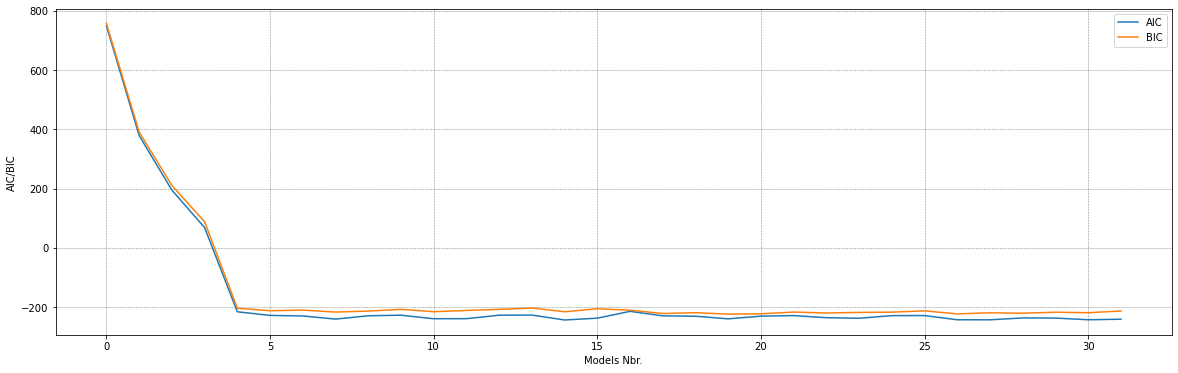

In [26]:
# Lineplot AIB/BIC

df_models_list = pd.DataFrame( np_models_list[:,:6],columns=['model_nbr','p','d','q','AIC','BIC'] )
df_models_list[['AIC','BIC']].plot()

plt.xlabel('Models Nbr.')
plt.ylabel('AIC/BIC')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.savefig('TS_04_aic-bic', bbox_inches='tight')

plt.show()

In [27]:
fig = px.line(df_models_list, x="model_nbr", y=["AIC","BIC"], title='AIC/BIC')
fig.show()

##### Predizione one-step con rimodellazione ######

In [28]:
# Modelliamo un ARIMA (p,d,q) e facciamo forecast sul test dataset

p = 2
d = 1
q = 3

In [29]:
start = time.time()

In [30]:
# Ad ogni passo del for aggiungo alla history un nuovo elemento preso dal "df_test"

predictions_arima = list()

history = df_train[timeseries]

len_test = df_test.shape[0]

for i in range(len_test):
    
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    
    yhat = model_fit.forecast().iloc[0]    # forecast
    
    predictions_arima.append(yhat)
    
    obs = df_test[timeseries].iloc[i]              # valore osservato da df_test
    #print(obs)
    
    history = history.append( pd.Series(obs) )   # all'history aggiungo il valore osservato del df_test (non uso la predizione)

In [31]:
end = time.time()
print(end - start)

71.28748345375061


In [32]:
df_test = df_test[[timeseries,timestamp]].iloc[0:]

df_test = df_test.reset_index(drop=True)

df_test['pred_arima'] = pd.Series(predictions_arima)

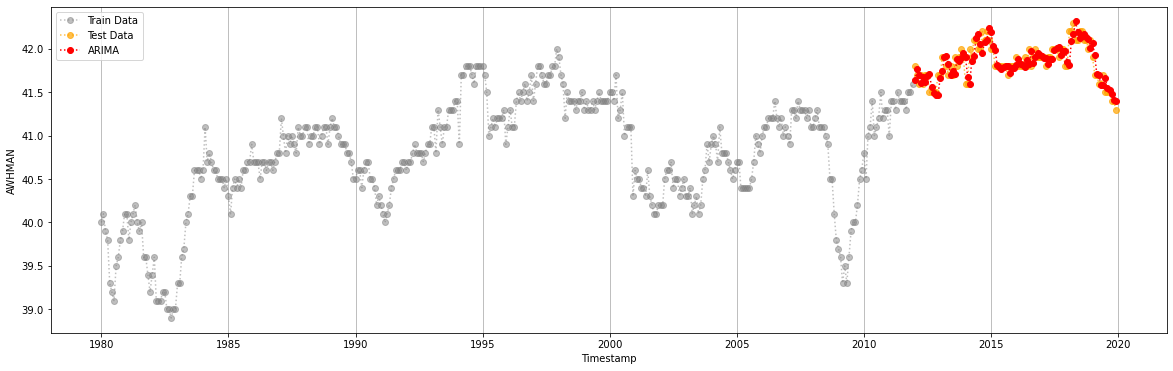

In [33]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp],df_train[timeseries],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],df_test['pred_arima'],'o:',alpha=1, color='red')

plt.legend(['Train Data','Test Data','ARIMA'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_arima-pred-day', bbox_inches='tight')
plt.show()

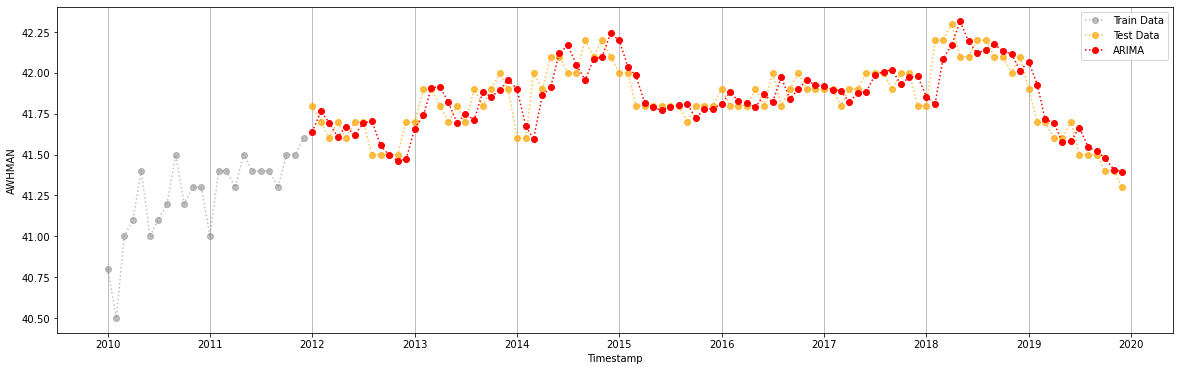

In [34]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[start_to_plot_train:],df_train[timeseries].iloc[start_to_plot_train:],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],df_test['pred_arima'],'o:',alpha=1, color='red')

plt.legend(['Train Data','Test Data','ARIMA'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_arima-pred-day_zoom_red', bbox_inches='tight')
plt.show()

In [35]:
mse = mean_squared_error(df_test[timeseries], df_test['pred_arima'])
mae = mean_absolute_error(df_test[timeseries], df_test['pred_arima'])

print('MSE ', mse)
print('RMSE ', sqrt(mse) )
print('MAE', mae)

MSE  0.014807119503324062
RMSE  0.12168450806624508
MAE 0.09266949539915285


In [36]:
df_test_results = df_test[ [timestamp,timeseries,'pred_arima'] ].copy()

#### RNN ####

In [37]:
# Setup variabili usate per la RNN

input_length = 10
hidden_length = 24

nbr_val_data = 15

epochs = 300

In [38]:
# Creiamo il dataset per l'addestramento (supervised) della RNN:
# dal df_train => Xtrain,Ytrain e Xval,Yval

# Eseguiamo la validazione sulle ultimi Nval dati del "df_train"
Nval = nbr_val_data

# Convertiamo il DataFrame "df_train" in un array Numpy
series = df_train[timeseries].dropna().to_numpy()

# Lunghezza dell'input
T = input_length

# Creiamo gli array X,Y usati nell'addestramento:
# X: array di T elementi => [t,...t+T-1]
# Y: valore T-esimo successivo => [t+T]

X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)

# Split di X e Y in (Xtrain, Ytrain) e (Xtest, Ytest)
Xtrain, Ytrain = X[:-Nval], Y[:-Nval]
Xval, Yval = X[-Nval:], Y[-Nval:]

In [39]:
#print(df_train.shape)
#print(Xtrain.shape,Ytrain.shape)
#print(Xval.shape,Yval.shape)
#print(df_test.shape)

In [40]:
# Definiamo la RNN

i = Input(shape=(T, 1))
x = LSTM(hidden_length)(i)
x = Dense(1)(x)
model = Model(i, x)

In [41]:
# Stampiamo un summary della rete

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


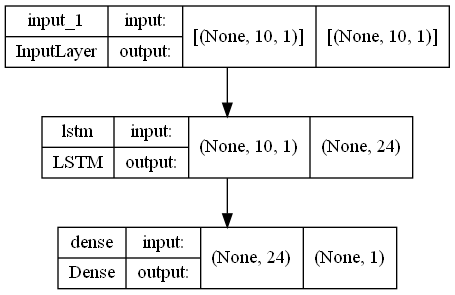

In [42]:
plot_model(model, to_file='TS_05_model_plot.png', show_shapes=True, show_layer_names=True)

In [43]:
# Configuriamo funzione di loss e optimizer della rete

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [44]:
# Istruimao la rete sul train (Xtrain, Ytrain) e la validiamo sul test (Xtest, Ytest)

r = model.fit(
  Xtrain,
  Ytrain,
  epochs=epochs,
  validation_data=(Xval, Yval)
)

Epoch 1/300
12/12 [==============================] - 4s 102ms/step - loss: 1659.2721 - val_loss: 1692.5516
Epoch 2/300
12/12 [==============================] - 0s 11ms/step - loss: 1630.9146 - val_loss: 1658.3876
Epoch 3/300
12/12 [==============================] - 0s 11ms/step - loss: 1595.1388 - val_loss: 1624.9659
Epoch 4/300
12/12 [==============================] - 0s 10ms/step - loss: 1565.7043 - val_loss: 1596.1161
Epoch 5/300
12/12 [==============================] - 0s 11ms/step - loss: 1534.3202 - val_loss: 1559.5493
Epoch 6/300
12/12 [==============================] - 0s 10ms/step - loss: 1493.9431 - val_loss: 1512.8573
Epoch 7/300
12/12 [==============================] - 0s 10ms/step - loss: 1442.1503 - val_loss: 1452.3047
Epoch 8/300
12/12 [==============================] - 0s 11ms/step - loss: 1377.8839 - val_loss: 1386.6257
Epoch 9/300
12/12 [==============================] - 0s 13ms/step - loss: 1321.5444 - val_loss: 1341.7509
Epoch 10/300
12/12 [=========================

12/12 [==============================] - 0s 9ms/step - loss: 387.7263 - val_loss: 407.0885
Epoch 80/300
12/12 [==============================] - 0s 9ms/step - loss: 380.8348 - val_loss: 400.0439
Epoch 81/300
12/12 [==============================] - 0s 8ms/step - loss: 374.0372 - val_loss: 393.1015
Epoch 82/300
12/12 [==============================] - 0s 8ms/step - loss: 367.3410 - val_loss: 386.2517
Epoch 83/300
12/12 [==============================] - 0s 9ms/step - loss: 360.7416 - val_loss: 379.4983
Epoch 84/300
12/12 [==============================] - 0s 9ms/step - loss: 354.2349 - val_loss: 372.8356
Epoch 85/300
12/12 [==============================] - 0s 10ms/step - loss: 347.8103 - val_loss: 366.2661
Epoch 86/300
12/12 [==============================] - 0s 9ms/step - loss: 341.4809 - val_loss: 359.7814
Epoch 87/300
12/12 [==============================] - 0s 8ms/step - loss: 335.2372 - val_loss: 353.3874
Epoch 88/300
12/12 [==============================] - 0s 11ms/step - loss: 3

12/12 [==============================] - 0s 9ms/step - loss: 72.4986 - val_loss: 81.4679
Epoch 158/300
12/12 [==============================] - 0s 9ms/step - loss: 70.6350 - val_loss: 79.4954
Epoch 159/300
12/12 [==============================] - 0s 8ms/step - loss: 68.8105 - val_loss: 77.5609
Epoch 160/300
12/12 [==============================] - 0s 9ms/step - loss: 67.0235 - val_loss: 75.6640
Epoch 161/300
12/12 [==============================] - 0s 9ms/step - loss: 65.2714 - val_loss: 73.8092
Epoch 162/300
12/12 [==============================] - 0s 9ms/step - loss: 63.5582 - val_loss: 71.9867
Epoch 163/300
12/12 [==============================] - 0s 8ms/step - loss: 61.8776 - val_loss: 70.2011
Epoch 164/300
12/12 [==============================] - 0s 9ms/step - loss: 60.2327 - val_loss: 68.4513
Epoch 165/300
12/12 [==============================] - 0s 8ms/step - loss: 58.6233 - val_loss: 66.7347
Epoch 166/300
12/12 [==============================] - 0s 8ms/step - loss: 57.0465 - va

Epoch 237/300
12/12 [==============================] - 0s 10ms/step - loss: 5.4149 - val_loss: 7.9317
Epoch 238/300
12/12 [==============================] - 0s 9ms/step - loss: 5.2073 - val_loss: 7.6737
Epoch 239/300
12/12 [==============================] - 0s 8ms/step - loss: 5.0073 - val_loss: 7.4215
Epoch 240/300
12/12 [==============================] - 0s 9ms/step - loss: 4.8125 - val_loss: 7.1799
Epoch 241/300
12/12 [==============================] - 0s 9ms/step - loss: 4.6277 - val_loss: 6.9450
Epoch 242/300
12/12 [==============================] - 0s 8ms/step - loss: 4.4489 - val_loss: 6.7181
Epoch 243/300
12/12 [==============================] - 0s 9ms/step - loss: 4.2766 - val_loss: 6.4971
Epoch 244/300
12/12 [==============================] - 0s 10ms/step - loss: 4.1098 - val_loss: 6.2826
Epoch 245/300
12/12 [==============================] - 0s 8ms/step - loss: 3.9473 - val_loss: 6.0756
Epoch 246/300
12/12 [==============================] - 0s 9ms/step - loss: 3.7925 - val_l

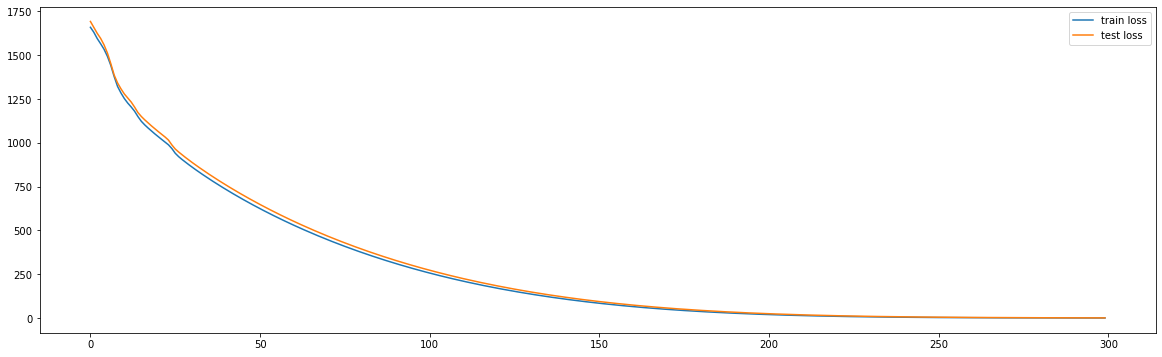

In [45]:
# Plot loss history del train e del test:
# possiamo vedere che convergono

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

##### Predizione one-step senza rimodellazione ######

In [46]:
start = time.time()

In [47]:
# Creiamo il dataset per eseguire le predizioni sul modello di RNN costruito

# Lunghezza dell'input == T

# Ultimi T elementi del df_train
series_trail_last10 = df_train[timeseries].iloc[-T:].to_numpy()

# Elementi del df_test
series_test_all = df_test[timeseries].dropna().to_numpy()

# Uniamo i due array Numpy
series_test = np.append(series_trail_last10, series_test_all)

# Creiamo gli array X,Y usati nell'addestramento:
# X: array di T elementi => [t,...t+T-1]
# Y: valore T-esimo successivo => [t+T]

X_test = []
Y_test = []
for t in range(len(series_test) - T):
  x = series_test[t:t+T]
  X_test.append(x)
  y = series[t+T]
  Y_test.append(y)

X_test = np.array(X_test).reshape(-1, T, 1)
Y_test = np.array(Y_test)

In [48]:
end = time.time()
print(end - start)

0.034818172454833984


In [49]:
forecast = model.predict(X_test).flatten()

In [50]:
#forecast

In [51]:
df_test['pred_RNN'] = forecast

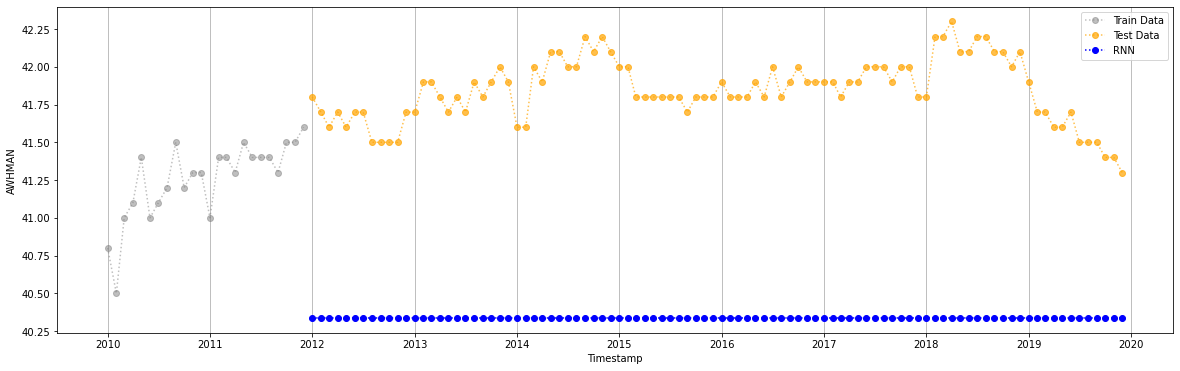

In [52]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[start_to_plot_train:],df_train[timeseries].iloc[start_to_plot_train:],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],df_test['pred_RNN'],'o:',alpha=1, color='blue')

plt.legend(['Train Data','Test Data','RNN'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_RNN-pred-day_zoom_blue', bbox_inches='tight')
plt.show()

In [53]:
mse = mean_squared_error(df_test[timeseries], df_test['pred_RNN'])
mae = mean_absolute_error(df_test[timeseries], df_test['pred_RNN'])

print('MSE ', mse)
print('RMSE ', sqrt(mse) )
print('MAE', mae)

MSE  2.316022250903867
RMSE  1.5218483008841146
MAE 1.507693227132161


##### Predizione one-step con rimodellazione ######

In [54]:
# Setup variabili usate per la RNN

input_length = 10
hidden_length = 24

nbr_val_data = 15

epochs = 250

df_train_rnn = df_train.copy()

In [55]:
start = time.time()

In [56]:
predictions_rnn = list()

len_test = df_test.shape[0]

for i_loop in range(len_test):

    # Creiamo il dataset per l'addestramento (supervised) della RNN:
    # dal df_train => Xtrain,Ytrain e Xval,Yval

    # Eseguiamo la validazione sulle ultimi Nval dati del "df_train"
    Nval = nbr_val_data

    # Convertiamo il DataFrame "df_train" in un array Numpy
    series = df_train_rnn[timeseries].dropna().to_numpy()

    # Lunghezza dell'input
    T = input_length

    # Creiamo gli array X,Y usati nell'addestramento:
    # X: array di T elementi => [t,...t+T-1]
    # Y: valore T-esimo successivo => [t+T]

    X = []
    Y = []
    for t in range(len(series) - T):
      x = series[t:t+T]
      X.append(x)
      y = series[t+T]
      Y.append(y)

    X = np.array(X).reshape(-1, T, 1)
    Y = np.array(Y)

    # Split di X e Y in (Xtrain, Ytrain) e (Xtest, Ytest)
    Xtrain, Ytrain = X[:-Nval], Y[:-Nval]
    Xval, Yval = X[-Nval:], Y[-Nval:]

    # RNN
    i = Input(shape=(T, 1))
    x = LSTM(24, return_sequences=True)(i)
    x = GlobalMaxPooling1D()(x)
    x = Dense(1)(x)
    model = Model(i, x)

    # Configuriamo funzione di loss e optimizer della rete

    model.compile(
        loss='mean_squared_error',
        optimizer='adam'
    )

    # Istruimao la rete sul train (Xtrain, Ytrain) e la validiamo sul test (Xtest, Ytest)

    r = model.fit(
      Xtrain,
      Ytrain,
      epochs=epochs,
      validation_data=(Xval, Yval),
      verbose=0
    )

    # Prendiamo gli ultimi 10 punti della X e prediciamo il valore T+1
    X = np.array(X).reshape(-1, T, 1)

    X_input10 = X[:1]

    # Prediciamo T+1
    forecast = model.predict(X_input10).flatten()

    # Aggiungo il forecast nella lista predictions_rnn
    predictions_rnn.append(forecast[0])

    # Prendo il valore i-esimo del df_test
    obs = df_test[timeseries].iloc[i_loop]
    obs_ts = df_test[timestamp].iloc[i_loop]

    # Aggiungo
    df_train_rnn = df_train_rnn.append({'y': obs, 'ds': obs_ts}, ignore_index = True) 

    #print(i_loop+1,"/",len_test)

In [57]:
end = time.time()
print(end - start)

2803.3266730308533


In [58]:
df_test = df_test[[timeseries,timestamp]].iloc[0:]

df_test = df_test.reset_index(drop=True)

df_test['pred_RNN_11'] = pd.Series(predictions_rnn)

In [59]:
df_test

AWHMAN  timestamp  pred_RNN_11
0     41.8 2012-01-01    39.864246
1     41.7 2012-02-01    40.086575
2     41.6 2012-03-01    38.483921
3     41.7 2012-04-01    39.824917
4     41.6 2012-05-01    39.825706
..     ...        ...          ...
91    41.5 2019-08-01    39.878178
92    41.5 2019-09-01    40.055969
93    41.4 2019-10-01    38.386112
94    41.4 2019-11-01    40.191380
95    41.3 2019-12-01    39.859730

[96 rows x 3 columns]

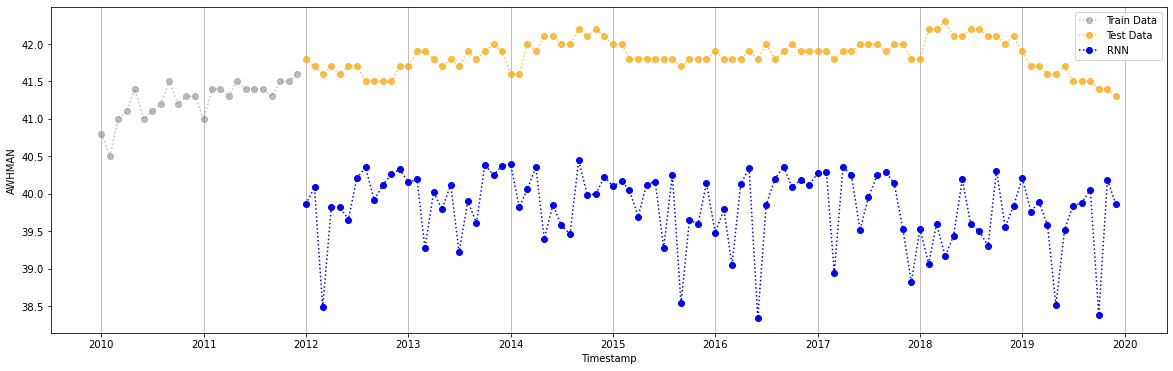

In [60]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[start_to_plot_train:],df_train[timeseries].iloc[start_to_plot_train:],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],df_test['pred_RNN_11'],'o:',alpha=1, color='blue')

plt.legend(['Train Data','Test Data','RNN'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_rnn-pred-day_zoom_00_blue', bbox_inches='tight')
plt.show()

In [61]:
mse = mean_squared_error(df_test[timeseries], df_test['pred_RNN_11'])
mae = mean_absolute_error(df_test[timeseries], df_test['pred_RNN_11'])

print('MSE ', mse)
print('RMSE ', sqrt(mse) )
print('MAE', mae)

MSE  4.358291104154989
RMSE  2.087652055337524
MAE 2.02231539885203


In [62]:
df_test_results['pred_RNN_11'] = df_test['pred_RNN_11']

#### Prophet ####

In [63]:
m = Prophet(growth='linear',
            n_changepoints=20,
            changepoint_range=0.8,
            weekly_seasonality=False, 
            daily_seasonality=False)

In [64]:
df_train_prophet = df_train[[timeseries,timestamp]].copy()

In [65]:
df_train_prophet = df_train_prophet.rename(columns={timeseries: "y", timestamp: "ds"})

In [66]:
df_train_prophet.head()

y         ds
253  40.0 1980-01-01
254  40.1 1980-02-01
255  39.9 1980-03-01
256  39.8 1980-04-01
257  39.3 1980-05-01

In [67]:
m.add_country_holidays(country_name = "US")

In [68]:
m.fit(df_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Costruiamo il DataFrame "future" che conterrà i valori di forecast.
Specifichiamo con "periods" il numero di step nel futuro che vogliamo predirre e "freq" la granularità delle predizioni.
Il DataFrame "future" conterrà sia le predizioni "in-sample" e "future" e inizialmente contiene solo le date "ds" che predirremo.

In [69]:
df_test.shape[0]

96

In [70]:
future = m.make_future_dataframe(periods=df_test.shape[0], freq='MS') # precisiamo che si tratta di mesi

Eseguiamo il forecast sulle date contenute in "future" => risultato in "forecast"

In [71]:
forecast = m.predict(future)

In [72]:
forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1980-01-01  39.514868   39.289664   40.179129    39.514868    39.514868   
1 1980-02-01  39.509312   39.404397   40.305488    39.509312    39.509312   
2 1980-03-01  39.504114   39.354614   40.226897    39.504114    39.504114   
3 1980-04-01  39.498558   39.377192   40.279827    39.498558    39.498558   
4 1980-05-01  39.493180   39.265574   40.161247    39.493180    39.493180   

   Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0            0.0                  0.0                  0.0   
1            0.0                  0.0                  0.0   
2            0.0                  0.0                  0.0   
3            0.0                  0.0                  0.0   
4            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...  holidays  holidays_lower  holidays_upper  \
0                       0.0  ...  3.155271        3.155271        3.155271   
1                       0.0  ...  0.000000        0.000000        0.000000   
2                       0.0  ...  0.000000        0.000000        0.000000   
3                       0.0  ...  0.000000        0.000000        0.000000   
4                       0.0  ...  0.000000        0.000000        0.000000   

     yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0 -2.953361     -2.953361     -2.953361                   0.0   
1  0.353277      0.353277      0.353277                   0.0   
2  0.280533      0.280533      0.280533                   0.0   
3  0.300205      0.300205      0.300205                   0.0   
4  0.211822      0.211822      0.211822                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0  39.716779  
1                         0.0                         0.0  39.862589  
2                         0.0                         0.0  39.784647  
3                         0.0                         0.0  39.798763  
4                         0.0                         0.0  39.705002  

[5 rows x 61 columns]

##### Predizione one-step senza rimodellazione ######

Plot dei forecast calcolati da Prophet richiamando la funzione plot di Prophet (senza e con trend + change points individuati)

In [73]:
start = time.time()

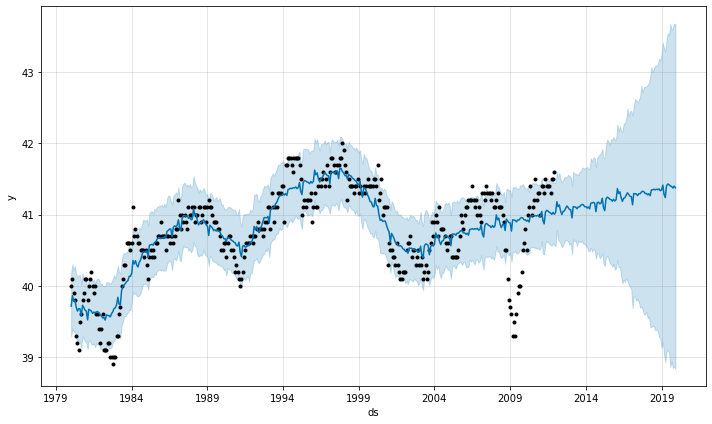

In [74]:
m.plot(forecast);

In [75]:
end = time.time()
print(end - start)

0.5365660190582275


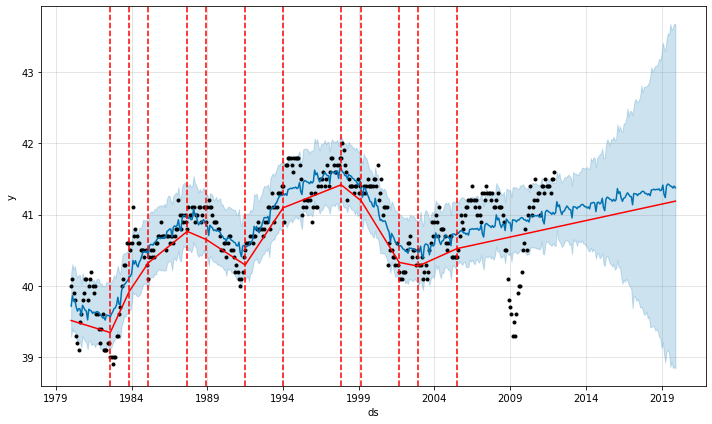

In [76]:
fig = m.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Plot delle componenenti trovate da Prophet: trend(t) e seas(t)

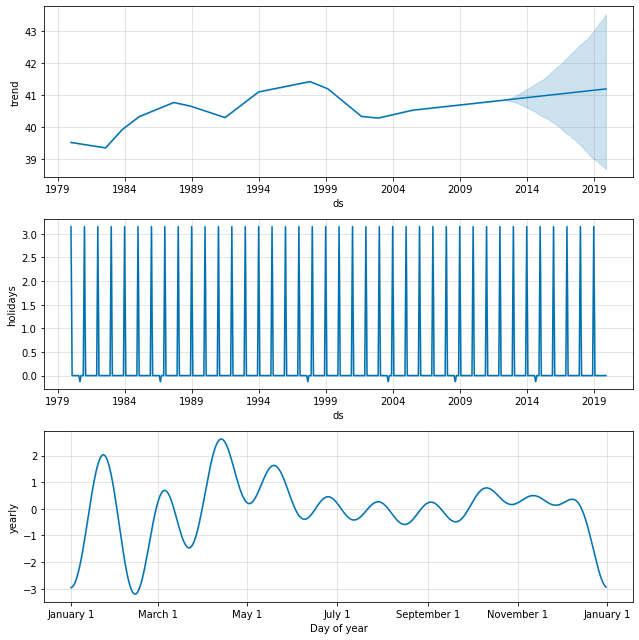

In [77]:
m.plot_components(forecast);

Disegno lo stesso diagramma creato in precedenza per ARIMA e RNN

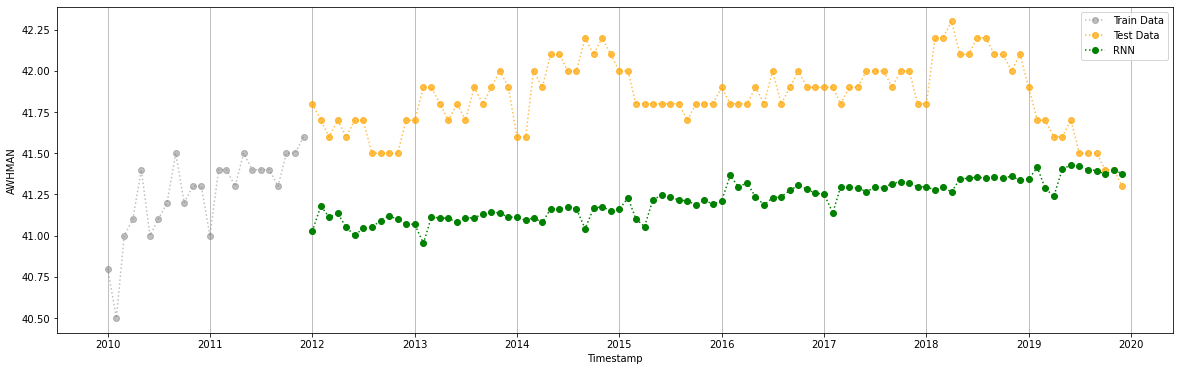

In [78]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[start_to_plot_train:],df_train[timeseries].iloc[start_to_plot_train:],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],forecast[-df_test.shape[0]:]['yhat'],'o:',alpha=1, color='green')

plt.legend(['Train Data','Test Data','RNN'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_06_Prophet-pred-day_zoom_green', bbox_inches='tight')
plt.show()

In [79]:
mse = mean_squared_error(df_test[timeseries], forecast[-df_test.shape[0]:]['yhat'])
mae = mean_absolute_error(df_test[timeseries], forecast[-df_test.shape[0]:]['yhat'])

print('MSE ', mse)
print('RMSE ', sqrt(mse) )
print('MAE', mae)

MSE  0.4449570855548483
RMSE  0.667051036694231
MAE 0.6278071130066252


##### Predizione one-step con rimodellazione ######

In [80]:
start = time.time()

In [81]:
# Ad ogni passo del for aggiungo alla history un nuovo elemento preso dal "df_test"

predictions_prophet = list()

history = df_train[timeseries]

len_test = df_test.shape[0]

df_train_prophet = df_train[[timeseries,timestamp]].copy()

df_train_prophet = df_train_prophet.rename(columns={timeseries: "y", timestamp: "ds"})

for i in range(len_test):
    
    m = Prophet(growth='linear',
            n_changepoints=20,
            changepoint_range=0.8,
            weekly_seasonality=False, 
            daily_seasonality=False)
    
    m.add_country_holidays(country_name = "US")
    
    m.fit(df_train_prophet)
    
    future = m.make_future_dataframe(periods=1, freq='MS') # precisiamo che si tratta di mesi
    
    forecast = m.predict(future)
    
    predictions_prophet.append(forecast['yhat'][-1:].values[0])

    obs = df_test[timeseries].iloc[i]
    obs_ts = df_test[timestamp].iloc[i]
    
    df_train_prophet = df_train_prophet.append({'y': obs, 'ds': obs_ts}, ignore_index = True)    

In [82]:
end = time.time()
print(end - start)

597.2288069725037


In [83]:
df_test = df_test[[timeseries,timestamp]].iloc[0:]

df_test = df_test.reset_index(drop=True)

df_test['pred_prophet'] = pd.Series(predictions_prophet)

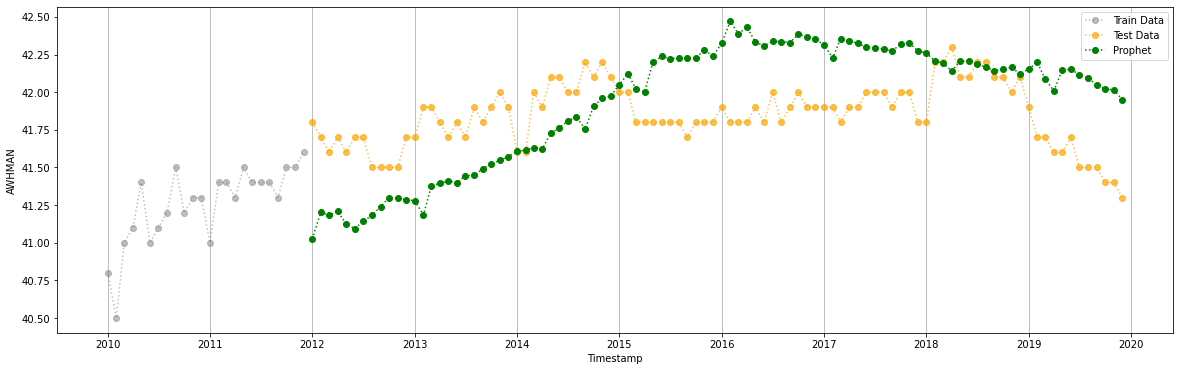

In [84]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[start_to_plot_train:],df_train[timeseries].iloc[start_to_plot_train:],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],df_test['pred_prophet'],'o:',alpha=1, color='green')

plt.legend(['Train Data','Test Data','Prophet'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_prophet-pred-day_zoom_00_green', bbox_inches='tight')
plt.show()

In [85]:
mse = mean_squared_error(df_test[timeseries], df_test['pred_prophet'])
mae = mean_absolute_error(df_test[timeseries], df_test['pred_prophet'])

print('MSE ', mse)
print('RMSE ', sqrt(mse) )
print('MAE', mae)

MSE  0.16404436205889897
RMSE  0.4050239030710397
MAE 0.3626518080537282


In [86]:
df_test_results['pred_prophet'] = df_test['pred_prophet']

---

##### Conclusione #####

In [87]:
df_test_results.head()

timestamp  AWHMAN  pred_arima  pred_RNN_11  pred_prophet
0 2012-01-01    41.8   41.638911    39.864246     41.025575
1 2012-02-01    41.7   41.764460    40.086575     41.202832
2 2012-03-01    41.6   41.696297    38.483921     41.181307
3 2012-04-01    41.7   41.608057    39.824917     41.207599
4 2012-05-01    41.6   41.669934    39.825706     41.125163

In [88]:
models_list = []

for col in ['pred_arima', 'pred_RNN_11', 'pred_prophet']:
    mse = mean_squared_error(df_test_results[timeseries], df_test_results[col])
    mae = mean_absolute_error(df_test_results[timeseries], df_test_results[col])
    m_list = []
    m_list.append(col)
    m_list.append(mse)
    m_list.append(sqrt(mse))
    m_list.append(mae)
    
    models_list.append(m_list)

In [89]:
print(tabulate(models_list,headers=['Model','MSE','RMSE','MAE']))

Model               MSE      RMSE        MAE
------------  ---------  --------  ---------
pred_arima    0.0148071  0.121685  0.0926695
pred_RNN_11   4.35829    2.08765   2.02232
pred_prophet  0.164044   0.405024  0.362652


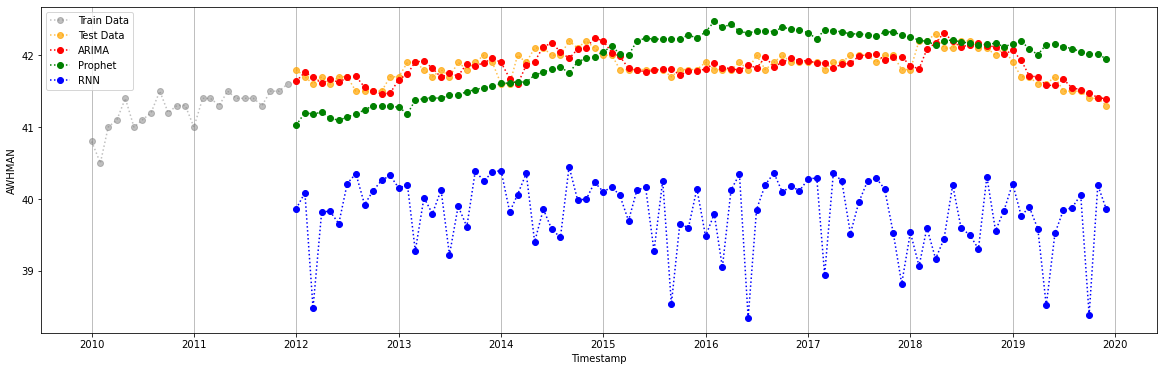

In [90]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[start_to_plot_train:],df_train[timeseries].iloc[start_to_plot_train:],'o:',alpha=0.5, color='grey')
plt.plot(df_test_results[timestamp],df_test_results[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test_results[timestamp],df_test_results['pred_arima'],'o:',alpha=1, color='red')

#predicted values
plt.plot(df_test_results[timestamp],df_test_results['pred_prophet'],'o:',alpha=1, color='green')

#predicted values
plt.plot(df_test_results[timestamp],df_test_results['pred_RNN_11'],'o:',alpha=1, color='blue')

plt.legend(['Train Data','Test Data','ARIMA','Prophet','RNN'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_pred-day_zoom', bbox_inches='tight')
plt.show()